In [22]:
import numpy as np
import matplotlib.pyplot as plt
import ibeaconsHelper
import trilateration
import CoreLocation


beacon_locations = {1: (171, 0), 2: (0, 108), 3: (0, 216), 4: (0, 0), 5: (279, 101), 6: (108, 251), 7:(121, 144), 8: (279, 179), 9: (273, 0)}
client_locations = {"cattalyya": (160, 109), "ray": (236, 88)}
# ray started at 12:45 am

In [23]:
beacon_locations_3D = {}
for minor, location in beacon_locations.items():
    x, y = location
    beacon_locations_3D[minor] = np.array([x, y, 0])

In [35]:
import json

#ray 1525668401385.json
with open('/root/6S062/indoor-loc/Server/collected_data/cattalyya-13-slow-old/ibeacons/1526267744849.json', 'r') as f:
    data = json.load(f)

In [37]:
data_by_timestamp = ibeaconsHelper.get_rssi_data_by_timestamp(data)

In [39]:
data_by_timestamp

{1526267690.364723: [RSSIData(1)@1526267690.36: rssi=-72,
  RSSIData(2)@1526267690.36: rssi=-68,
  RSSIData(4)@1526267690.36: rssi=-81,
  RSSIData(5)@1526267690.36: rssi=-79,
  RSSIData(8)@1526267690.36: rssi=-79,
  RSSIData(9)@1526267690.36: rssi=-73],
 1526267690.465251: [RSSIData(1)@1526267690.47: rssi=-74,
  RSSIData(2)@1526267690.47: rssi=-69,
  RSSIData(3)@1526267690.47: rssi=-52,
  RSSIData(4)@1526267690.47: rssi=-76,
  RSSIData(5)@1526267690.47: rssi=-73,
  RSSIData(8)@1526267690.47: rssi=-75,
  RSSIData(9)@1526267690.47: rssi=-72],
 1526267690.5675821: [RSSIData(1)@1526267690.57: rssi=-74,
  RSSIData(2)@1526267690.57: rssi=-69,
  RSSIData(3)@1526267690.57: rssi=-52,
  RSSIData(4)@1526267690.57: rssi=-76,
  RSSIData(5)@1526267690.57: rssi=-78,
  RSSIData(7)@1526267690.57: rssi=-68,
  RSSIData(8)@1526267690.57: rssi=-74,
  RSSIData(9)@1526267690.57: rssi=-72],
 1526267690.665149: [RSSIData(1)@1526267690.67: rssi=-83,
  RSSIData(2)@1526267690.67: rssi=-69,
  RSSIData(3)@152626769

### Average prediction over 1 minute

In [40]:
sumX = 0
sumY = 0
timestamp_len = float(len(data_by_timestamp.keys()))
print("Time Length: ", timestamp_len)
for t in data_by_timestamp.keys():
    currPredPos, beacon_points = predict_at_timestamp(data_by_timestamp, beacon_locations, t)
    sumX += currPredPos['x']
    sumY += currPredPos['y']

predictedPos = {'x': sumX/timestamp_len, 'y': sumY/timestamp_len, 'z': 0.0, 'sigPower': None}

('Time Length: ', 545.0)


NameError: name 'predict_at_timestamp' is not defined

(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 7)
(6, 8)
(6, 9)
(7, 8)
(7, 9)
(8, 9)


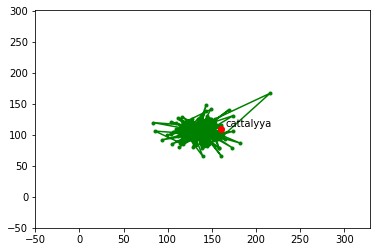

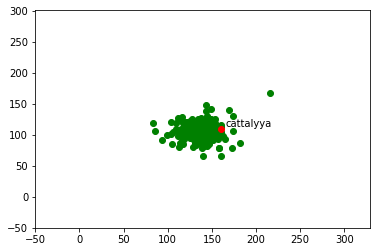

In [42]:
timestamp = 1525668397.2775578 # ray
# timestamp = 1525666731.260067 # cattalyya
conversion = 39.97 # meters to inches
A = -77
n = 2

subject_name = "cattalyya"
predicted_locations = CoreLocation.Locations(subject=subject_name)
xs, ys = zip(*beacon_locations.values())
margin = 50
axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
for timestamp in data_by_timestamp.keys():
    rssi_values = ibeaconsHelper.get_rssi_values(data_by_timestamp, timestamp)
    beacon_distances = ibeaconsHelper.get_beacon_distances_from_rssi(rssi_values, A, n, conversion)
    predicted_loc = trilateration.trilaterate(beacon_locations, beacon_distances, L2=True)
    # TODO: check why None result from trilateration
    if predicted_loc is not None:
        predicted_locations.add_np_point(predicted_loc, timestamp)
    
subject_point = CoreLocation.Point2D.numpy_to_point(client_locations[subject_name], None)
# predicted_locations.visualize(subject_point, ax_limits=axis_limits)
# predicted_locations.plot(subject_point, ax_limits=axis_limits)

# Hyperbolic multilateration 
import itertools
rssi = ibeaconsHelper.get_rssi_values(data_by_timestamp, data_by_timestamp.keys()[0])
beacon_distances = ibeaconsHelper.get_beacon_distances_from_rssi(rssi, A, n, conversion)
beaconids = rssi.keys()

pairs = itertools.combinations(beaconids, 2)
distance_ratios = {}
for pair in pairs:
    print pair
    id1, id2 = pair[0], pair[1]
    distance_ratios[pair] = beacon_distances[id1]/beacon_distances[id2]
    
predicted_loc = trilateration.trilaterate_ratios(beacon_locations, distance_ratios, pairs)
    

Should we filter out data if rssi are too low? It's no longer reliable after it's below some threshold.

# Results

In [26]:
def plot_prediction(beacon_locations, beacon_distances, predicted_location, client_names):
    margin = 50
    xs, ys = zip(*beacon_locations.values())
    axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
    fig, ax = plt.subplots()
    
    # assume all beacons in beacon_distances are also in beacon_locations
    for minor in beacon_distances:
        x, y = beacon_locations[minor][:2]
        distance = beacon_distances[minor]
        circle = plt.Circle((x, y), distance, fill=False)
        ax.add_artist(circle)
        ax.plot(x, y, 'bo')
        ax.annotate(minor, (x, y), xytext=(x + 5, y + 5))

    for client_name in client_names:
        x, y = client_locations[client_name]
        ax.plot(x, y, 'go')
        ax.annotate(client_name, (x, y), xytext=(x + 5, y + 5))

    # prediction
    predicted_x, predicted_y = predicted_location[:2]
    ax.plot(predicted_x, predicted_y, 'ro')
    ax.annotate("prediction", (predicted_x, predicted_y), xytext=(predicted_x + 5, predicted_y + 5))
    plt.axis(axis_limits)
    ax.axis('equal')
    plt.title("A: %.2f, n: %.2f" % (A, n))
    plt.show()

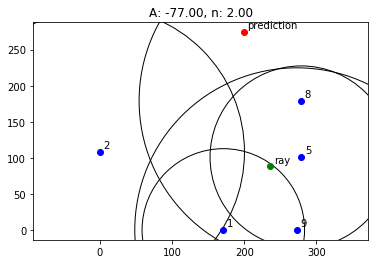

In [27]:
plot_prediction(beacon_locations, beacon_distances, predicted_locations.points[10].coord, ["ray"])

In [16]:
print rssi_values

{8: -92, 1: -86, 2: -91, 5: -87, 9: -92}
